### Importing package

In [1]:
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
# Extra Credit

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Read Clean Data sets from File

In [2]:
data = pd.read_csv('C:\\Users\\nbpat\\Desktop\\ML Project\\communities-crime-clean.csv')

In [3]:
data.shape

(1993, 104)

# 1. Decision Trees

## Que[1(a)] Create a new field “highCrime” which is true if the crime rate per capita (ViolentCrimesPerPop) is greater than 0.1, and false otherwise. 

In [4]:
data['highCrime'] = (data['ViolentCrimesPerPop']>0.1)
c = Counter()
c.update(data.highCrime)
print ("Positive HighCrime Instances: %.2f %% " % (c[True]/len(data.highCrime)*100))
print("Negative HighCrime Instances:  %.2f %%" % (c[False]/len(data.highCrime)*100))

Positive HighCrime Instances: 62.72 % 
Negative HighCrime Instances:  37.28 %


### removing non predictive features from data frame

In [5]:
data_copy = data.copy()

del data['state']
del data['communityname']
del data['fold']
del data['ViolentCrimesPerPop']


In [6]:
columns = data.columns[:-1]
Target = data[data.columns[-1]]
data = pd.DataFrame(data,columns=columns)

### Finding Depth of the tree to avoid possible overfitting by maximizing cv results

#### Graph shows, for max_depth=3, DecisionTreeClassifier gives best cv results

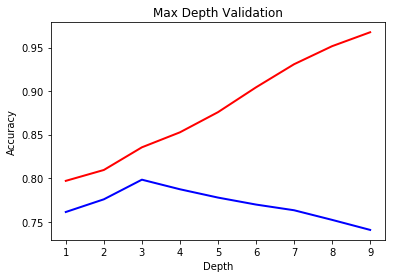

In [7]:
X_data = data
y_target = Target
train_data_score, test_data_score = validation_curve(DecisionTreeClassifier(),X_data,y_target,param_name='max_depth',param_range=range(1,10),cv=10,scoring="accuracy")
train_score_mean =np.mean(train_data_score, axis=1)
test_score_mean =np.mean(test_data_score, axis=1)

plt.title("Max Depth Validation")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
lw=2
plt.plot(range(1,10),train_score_mean,label="Training score",color="RED",lw=lw)
plt.plot(range(1,10),test_score_mean,label="Cross-validation score",color="BLUE",lw=lw)
plt.show()

### Fitting Data to Decision Tree Classifier

In [8]:
tree = DecisionTreeClassifier(random_state=0,max_depth=3)
tree.fit(X_data,y_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

### b.i Trainig accuracy, Precision and Recall for the DecisionTreeClassifier using Training data

In [9]:
print("Accuracy on Decision Tree: %.4f"% (tree.score(X_data,y_target)))
print("Precision on Decision Tree: %.4f"% (precision(y_target,tree.predict(X_data))))
print("Recall on Decision Tree: %.4f"% (recall(y_target,tree.predict(X_data))))

Accuracy on Decision Tree: 0.8359
Precision on Decision Tree: 0.9003
Recall on Decision Tree: 0.8304


### b.ii Main Features used in classification

In [10]:
importance_tree = tree.feature_importances_
indices_tree = np.argsort(importance_tree)[::-1]
print("Top 10 Features used in classification.\n\n")
for f in range(0,4):
    print("%d. feature %d (%f)  ==> %s" % (f + 1, indices_tree[f], importance_tree[indices_tree[f]],data.columns[indices_tree[f]]))

Top 10 Features used in classification.


1. feature 44 (0.719944)  ==> PctKids2Par
2. feature 3 (0.168307)  ==> racePctWhite
3. feature 5 (0.091650)  ==> racePctHisp
4. feature 71 (0.020099)  ==> HousVacant


### Feature importance graph with (Y=>X) <==>(FeatureName ==> FeatureImportance)

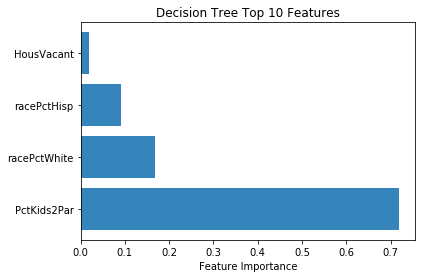

In [11]:
x_obj = []
for f in range(0,4):
    x_obj.append(data.columns[indices_tree[f]])
y_pos =np.arange(len(x_obj))
y_val =np.sort(importance_tree)[::-1][0:4]

plt.barh(y_pos,y_val,align='center',alpha=0.9)
plt.yticks(y_pos,x_obj)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Top 10 Features")

plt.show()


###  Draw Decision Tree Graph

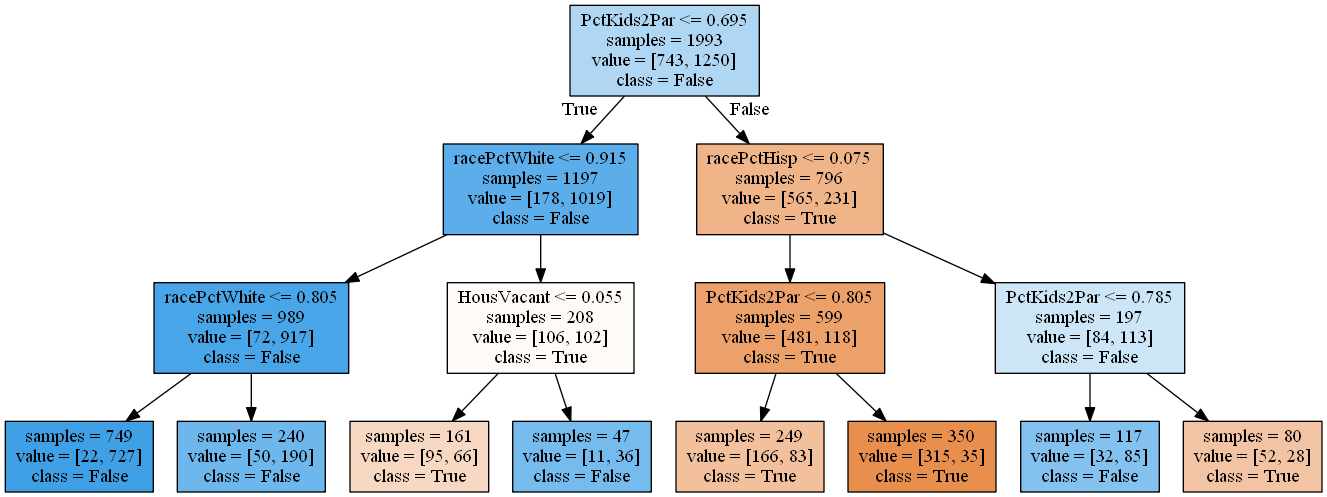

In [12]:
export_graphviz(tree, out_file="tree.dot", class_names=["True", "False"],
                feature_names=X_data.columns, impurity=False, filled=True)


graph = pydotplus.graph_from_dot_file('tree.dot')
#graph.write_png('tree.png')
Image(graph.create_png())

### c.i Cross Val Score for Decision Tree Classifier using 10-fold CrossValidation

In [13]:
tree_accuracy=cross_val_score(tree,X_data,y_target,cv=10)
tree_precision = cross_val_score(tree,X_data,y_target,cv=10,scoring='precision')
tree_recall =cross_val_score(tree,X_data,y_target,cv=10,scoring='recall')

print("DecisionTreeClassifier Accuracy : %.4f (+/- %.4f)"% (tree_accuracy.mean(),tree_accuracy.std()*2))
print("DecisionTreeClassifier Precision: %.4f (+/- %.4f)"% (tree_precision.mean(),tree_precision.std()*2))
print("DecisionTreeClassifier Recall: %.4f (+/- %.4f)"% (tree_recall.mean(),tree_recall.std()*2))


DecisionTreeClassifier Accuracy : 0.7982 (+/- 0.1183)
DecisionTreeClassifier Precision: 0.8433 (+/- 0.1053)
DecisionTreeClassifier Recall: 0.8392 (+/- 0.2073)


## c.ii ii.	Why are they different from the results in the previous test?

## ANS[c.ii]
### During the first test case, we fit the DecisionTreeClassifier on whole data sets and we measure accuracy on it. So as there is no bias ( i.e. Overfitting) , it will give us high accuracy, precision and Recall value. But as for the Cross Validation, we have split data to exact 10 fold and trained our model on 9 fold and tested with 1 fold for 10 time by taking each time different training and test data sets. So eventually, there will be bias and it will give accuracy, precision and recall value less than previous one.

# 2.	Linear Classification

### GaussianNB

In [14]:
gnb_clf =GaussianNB()
gnb_clf.fit(X_data,y_target)

GaussianNB(priors=None)

### (i) The 10-fold cross-validation accuracy, precision, and recall 

In [15]:
accuracy_score = cross_val_score(gnb_clf,X_data,y_target,cv=10)
precision_score = cross_val_score(gnb_clf,X_data,y_target,cv=10,scoring='precision')
recall_score = cross_val_score(gnb_clf,X_data,y_target,cv=10,scoring='recall')

print("GaussianNB  Accuracy: %0.3f (+/- %0.3f)"%(accuracy_score.mean(),accuracy_score.std()*2))
print("GaussianNB  Precision: %0.3f (+/- %0.3f)"%(precision_score.mean(),precision_score.std()*2))
print("GaussianNB  Recall: %0.3f (+/- %0.3f)"%(recall_score.mean(),recall_score.std()*2))

GaussianNB  Accuracy: 0.762 (+/- 0.108)
GaussianNB  Precision: 0.912 (+/- 0.116)
GaussianNB  Recall: 0.692 (+/- 0.183)


### (ii) The 10 most predictive features

In [16]:
top_gnb_features = np.abs(gnb_clf.theta_[0]-gnb_clf.theta_[1])/(gnb_clf.sigma_[0]+gnb_clf.sigma_[1])
top_indices_GNB=top_gnb_features.argsort()[::-1]
top_gnb_features= np.sort(top_gnb_features)[::-1]
print ("Top 10 GaussianNB Features\n\n")
for i in range(0,10):
    print("%d. Features %d (%f) => %s"%(i+1,top_indices_GNB[i],top_gnb_features[i],X_data.columns[top_indices_GNB[i]]))
    

Top 10 GaussianNB Features


1. Features 44 (5.001310) => PctKids2Par
2. Features 40 (4.756886) => FemalePctDiv
3. Features 43 (4.593988) => PctFam2Par
4. Features 15 (4.394991) => pctWInvInc
5. Features 41 (4.385986) => TotalPctDiv
6. Features 46 (3.999354) => PctTeen2Par
7. Features 38 (3.950731) => MalePctDivorce
8. Features 45 (3.648301) => PctYoungKids2Par
9. Features 50 (3.469889) => PctIlleg
10. Features 3 (3.443228) => racePctWhite


#### Comments: As the (gnb_clf.theta_[0]-gnb_clf.theta_[1])  gives the distance betweet two features, the larger the difference , a feature can be diffrentiated well. That's why, the given equation is able to predict  more predictive features.

### Feature importance graph with (Y=>X) <==>(FeatureName ==> FeatureImportance)

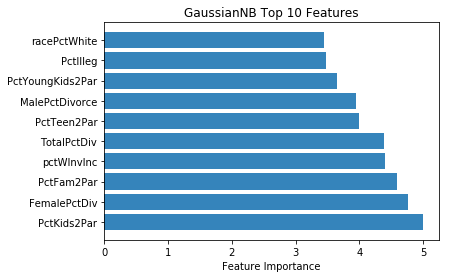

In [17]:
x_obj = []
for f in range(0,10):
    x_obj.append(data.columns[top_indices_GNB[f]])
y_pos =np.arange(len(x_obj))
y_val =np.sort(top_gnb_features)[::-1][0:10]

plt.barh(y_pos,y_val,align='center',alpha=0.9)
plt.yticks(y_pos,x_obj)
plt.xlabel("Feature Importance")
plt.title("GaussianNB Top 10 Features")

plt.show()

### (iii) How do these results compare with your results from decision trees, above?

DT: 0.798244 (0.059135)
GNB: 0.761608 (0.054241)


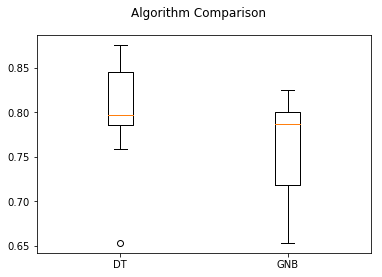

In [18]:
models =[]
models.append(("DT",DecisionTreeClassifier(max_depth=3)))
models.append(("GNB",GaussianNB()))

results=[]
names=[]
scoring='accuracy'
for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(model, X_data, y_target, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
    


### Top 10 Predictive Features comparision

In [19]:
for i in range(0,10):   
    print("%-3d. GaussianNB Feature:(%3d)   %-20s \t DecisionTreeClassifier (%3d)  %-20s"%(i+1,top_indices_GNB[i],X_data.columns[top_indices_GNB[i]], indices_tree[i],data.columns[indices_tree[i]]))

1  . GaussianNB Feature:( 44)   PctKids2Par          	 DecisionTreeClassifier ( 44)  PctKids2Par         
2  . GaussianNB Feature:( 40)   FemalePctDiv         	 DecisionTreeClassifier (  3)  racePctWhite        
3  . GaussianNB Feature:( 43)   PctFam2Par           	 DecisionTreeClassifier (  5)  racePctHisp         
4  . GaussianNB Feature:( 15)   pctWInvInc           	 DecisionTreeClassifier ( 71)  HousVacant          
5  . GaussianNB Feature:( 41)   TotalPctDiv          	 DecisionTreeClassifier ( 99)  LemasPctOfficDrugUn 
6  . GaussianNB Feature:( 46)   PctTeen2Par          	 DecisionTreeClassifier ( 35)  PctEmplProfServ     
7  . GaussianNB Feature:( 38)   MalePctDivorce       	 DecisionTreeClassifier ( 27)  NumUnderPov         
8  . GaussianNB Feature:( 45)   PctYoungKids2Par     	 DecisionTreeClassifier ( 28)  PctPopUnderPov      
9  . GaussianNB Feature:( 50)   PctIlleg             	 DecisionTreeClassifier ( 29)  PctLess9thGrade     
10 . GaussianNB Feature:(  3)   racePctWhite  

### Comparision Results:
#### By comparing GaussianNB and DecisionTreeClassifier, DecisionTreeClassifier gives better accuracy on dataset. and PctKids2Par is the same most predictive features in both the model

### LinearSVC 

In [20]:

svm_clf = svm.LinearSVC()
svm_clf.fit(X_data,y_target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### (i) The 10-fold cross-validation accuracy, precision, and recall 

In [21]:
accuracy_score = cross_val_score(svm_clf,X_data,y_target,cv=10)
precision_score = cross_val_score(svm_clf,X_data,y_target,cv=10,scoring='precision')
recall_score = cross_val_score(svm_clf,X_data,y_target,cv=10,scoring='recall')

print("LinearSVC  Accuracy: %0.3f (+/- %0.3f)"%(accuracy_score.mean(),accuracy_score.std()*2))
print("LinearSVC  Precision: %0.3f (+/- %0.3f)"%(precision_score.mean(),precision_score.std()*2))
print("LinearSVC  Recall: %0.3f (+/- %0.3f)"%(recall_score.mean(),recall_score.std()*2))

LinearSVC  Accuracy: 0.796 (+/- 0.109)
LinearSVC  Precision: 0.845 (+/- 0.100)
LinearSVC  Recall: 0.834 (+/- 0.233)


### (ii) The 10 most predictive features

In [22]:
top_svm_features=np.abs(svm_clf.coef_)
top_svm_features = top_svm_features.flatten()

top_indices_SVM = top_svm_features.argsort()[::-1]
top_svm_features = np.sort(top_svm_features)[::-1]
print ("Top 10 LinearSVC Features\n\n")
for i in range(0,10):
    print("%d. Features %d (%f) => %s"%(i+1,top_indices_SVM[i],top_svm_features[i],X_data.columns[top_indices_SVM[i]]))

Top 10 LinearSVC Features


1. Features 15 (1.888487) => pctWInvInc
2. Features 64 (1.755126) => PersPerOccupHous
3. Features 3 (1.500219) => racePctWhite
4. Features 44 (1.190329) => PctKids2Par
5. Features 84 (1.066884) => RentHighQ
6. Features 38 (1.065696) => MalePctDivorce
7. Features 27 (1.051548) => NumUnderPov
8. Features 90 (1.019155) => NumStreet
9. Features 37 (1.014672) => PctOccupMgmtProf
10. Features 0 (1.002301) => population


#### Comments: As the Coef is the weight assigend to each features in Linear Model, higher the weight value, more predictive the feature. 

### Feature importance graph with (Y=>X) <==>(FeatureName ==> FeatureImportance)

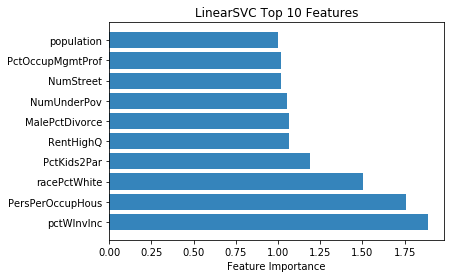

In [23]:
x_obj = []
for f in range(0,10):
    x_obj.append(data.columns[top_indices_SVM[f]])
y_pos =np.arange(len(x_obj))
y_val =np.sort(top_svm_features)[::-1][0:10]

plt.barh(y_pos,y_val,align='center',alpha=0.9)
plt.yticks(y_pos,x_obj)
plt.xlabel("Feature Importance")
plt.title("LinearSVC Top 10 Features")

plt.show()

### (iii) Compare Result with DecisionTreeClassifier

#### from the whisker  plot graph, LinearSVC gives better accuracy on data sets

DT: 0.727995 (0.052858)
SVM: 0.796234 (0.054686)


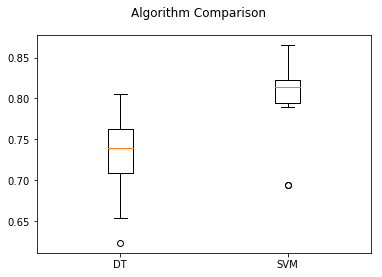

In [24]:
models =[]
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVM",svm.LinearSVC()))

results=[]
names=[]
scoring='accuracy'
for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(model, X_data, y_target, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
    


### Top 10 Predictive feature comparision

In [25]:
for i in range(0,10):   
    print("%-3d. LinearSVC Feature:(%3d)   %-20s \t DecisionTreeClassifier (%3d)  %-20s"%(i+1,top_indices_SVM[i],X_data.columns[top_indices_SVM[i]], indices_tree[i],data.columns[indices_tree[i]]))

1  . LinearSVC Feature:( 15)   pctWInvInc           	 DecisionTreeClassifier ( 44)  PctKids2Par         
2  . LinearSVC Feature:( 64)   PersPerOccupHous     	 DecisionTreeClassifier (  3)  racePctWhite        
3  . LinearSVC Feature:(  3)   racePctWhite         	 DecisionTreeClassifier (  5)  racePctHisp         
4  . LinearSVC Feature:( 44)   PctKids2Par          	 DecisionTreeClassifier ( 71)  HousVacant          
5  . LinearSVC Feature:( 84)   RentHighQ            	 DecisionTreeClassifier ( 99)  LemasPctOfficDrugUn 
6  . LinearSVC Feature:( 38)   MalePctDivorce       	 DecisionTreeClassifier ( 35)  PctEmplProfServ     
7  . LinearSVC Feature:( 27)   NumUnderPov          	 DecisionTreeClassifier ( 27)  NumUnderPov         
8  . LinearSVC Feature:( 90)   NumStreet            	 DecisionTreeClassifier ( 28)  PctPopUnderPov      
9  . LinearSVC Feature:( 37)   PctOccupMgmtProf     	 DecisionTreeClassifier ( 29)  PctLess9thGrade     
10 . LinearSVC Feature:(  0)   population           	 D

### Comparision Results
#### By comparing LinearSVC with DecisionTreeClassifier,  LinearSVC gives better results and   PctKids2Par and racePctWhite both are common most top 10 important features in the model

# 3.	Regression

### LinearRegression 

In [69]:
y_target_violentCrimesPerPop = data_copy['ViolentCrimesPerPop']
lr_clf = linear_model.LinearRegression()
lr_clf.fit(X_data,y_target_violentCrimesPerPop)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### (i) Using 10-fold cross-validation, the estimated mean-squared-error (MSE) 

In [70]:
y_lr_predict = cross_val_predict(lr_clf,X_data,y_target_violentCrimesPerPop,cv=10)

pt_x1 = mean_squared_error(y_target_violentCrimesPerPop,y_lr_predict)
print("The estimated mean-squared-error (MSE): %f "%(pt_x1))

The estimated mean-squared-error (MSE): 0.020103 


### (ii) The MSE on the training set 

In [71]:
y_lr_train_predict = lr_clf.predict(X_data)
print("The estimated mean-squared-error (MSE): %f "%(mean_squared_error(y_target_violentCrimesPerPop,y_lr_train_predict)))

The estimated mean-squared-error (MSE): 0.016517 


### (iii) Top 10 predictive features of a high crime rate

### So most Predictive Features in High Crime Rate is PersPerOccupHous

In [72]:
lr_coeff_high_crime = np.argsort(lr_clf.coef_)[::-1]
print("Top 10 Features for High Crime Rate:")
for i in range(0,10):
    print("%2d. Features:    %s"%(i+1, X_data.columns[lr_coeff_high_crime[i]]))

Top 10 Features for High Crime Rate:
 1. Features:    PersPerOccupHous
 2. Features:    PctHousOwnOcc
 3. Features:    MalePctDivorce
 4. Features:    PctRecImmig8
 5. Features:    MedRent
 6. Features:    medFamInc
 7. Features:    PctEmploy
 8. Features:    MalePctNevMarr
 9. Features:    PctPersDenseHous
10. Features:    OwnOccMedVal


### (iii) Top 10 predictive features of a low crime rate

#### So most Predictive features of a low crime rate is  PctPersOwnOccup

In [74]:
lr_coeff_low_crime  = np.argsort(lr_clf.coef_)
print("Top 10 Features for Low Crime Rate:")
for i in range(0,10):
    print("%2d. Features:  %s"%(i+1, X_data.columns[lr_coeff_low_crime[i]]))

Top 10 Features for Low Crime Rate:
 1. Features:  PctPersOwnOccup
 2. Features:  TotalPctDiv
 3. Features:  whitePerCap
 4. Features:  PctKids2Par
 5. Features:  OwnOccLowQuart
 6. Features:  numbUrban
 7. Features:  PersPerRentOccHous
 8. Features:  RentLowQ
 9. Features:  agePct12t29
10. Features:  PctRecImmig5


###  Ridge Regression

In [75]:
red_regcv_clf = linear_model.RidgeCV(alphas=[10, 1, 0.1, 0.01, 0.001])
red_regcv_clf.fit(X_data,y_target_violentCrimesPerPop)
print("Best Alpha Among [10, 1, 0.1, 0.01, and 0.001] is  %.3f"%(red_regcv_clf.alpha_))

Best Alpha Among [10, 1, 0.1, 0.01, and 0.001] is  1.000


### Ridge Regression using RidgeCV alpha value =1.0

In [76]:
red_reg_clf = linear_model.Ridge(alpha=1.0)
red_reg_clf.fit(X_data,y_target_violentCrimesPerPop)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### (i) The estimated MSE of the model under 10-fold CV

In [77]:
y_red_reg_predict = cross_val_predict(red_reg_clf,X_data,y_target_violentCrimesPerPop,cv=10)
print("The estimated mean-squared-error (MSE): %f "%(mean_squared_error(y_target_violentCrimesPerPop,y_red_reg_predict)))

The estimated mean-squared-error (MSE): 0.019804 


### (ii) The MSE on the training set 

In [78]:
y_red_reg_train_predict = red_reg_clf.predict(X_data)
print("The estimated mean-squared-error (MSE): %f "%(mean_squared_error(y_target_violentCrimesPerPop,y_red_reg_train_predict)))

The estimated mean-squared-error (MSE): 0.016764 


### (iii) Best Alpha

In [79]:
print("Best Alpha Among [10, 1, 0.1, 0.01, and 0.001] is  %.3f"%(red_regcv_clf.alpha_))

Best Alpha Among [10, 1, 0.1, 0.01, and 0.001] is  1.000


### (iv).	What does this say about the amount of overfitting in linear regression for this problem?

#### As here MSE for 10-fold CV is less for Ridge regression, it will reduce overfitting compare to linear regression model

## polynomial features 

In [36]:
poly_clf = PolynomialFeatures(degree=2)
poly_data = poly_clf.fit_transform(X_data)

### (i) The estimated MSE of the model under 10-fold CV

In [37]:
lr_clf.fit(poly_data,y_target_violentCrimesPerPop)

y_poly_predict = cross_val_score(lr_clf,poly_data,y_target_violentCrimesPerPop,cv=10,scoring='neg_mean_squared_error')

pt_x2 =y_poly_predict.mean()*-1
print("The estimated MSE of the model under 10-fold CV: %f"%(pt_x2))

The estimated MSE of the model under 10-fold CV: 0.129898


### (ii) The MSE on the training set 

In [38]:
y_poly_predict = lr_clf.predict(poly_data)

print("The estimated mean-squared-error (MSE): %f "%(mean_squared_error(y_target_violentCrimesPerPop,y_poly_predict)))

The estimated mean-squared-error (MSE): 0.000000 


### iii.	Does this mean the quadratic model is better than the linear model for this problem?


#### By comparing both the MSE, quadratic model will give overfitting. As with increasing the degree of polynomial, it will accomodate more data compare to linear model. So Quadratic Model is not better than linear model

# 4. Dirty Data

### Read dirty Data from CSV file

#### In dirty data '?' represent NaN value. Replaced '?' with NaN  using pandas dataframe at the time of reading data

In [39]:
dirty_data = pd.read_csv('C:\\Users\\nbpat\\Desktop\\ML Project\\communities-crime-full.csv',na_values=['?'])

### Replace NaN value with the Decimal mean value of county and community column as those column represent county and community code

### For rest of the column, replace NaN values with the mean value of the respective column

In [40]:
dirty_data_copy = dirty_data.copy()


del dirty_data['state']
del dirty_data['community']
del dirty_data['county']
del dirty_data['communityname']
del dirty_data['fold']



for i in dirty_data:
    if (dirty_data[i].dtypes!=object):
        dirty_data[i].fillna(dirty_data[i].mean(),inplace=True)

In [41]:
dirty_data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


### Creating New Field HighCrime in  based on  value of 'ViolentCrimesPerPop' 

In [42]:
dirty_data['highCrime'] = (dirty_data[dirty_data.columns[-1]]>0.1)
c = Counter()
c.update(dirty_data.highCrime)
print ("Positive HighCrime Instances: %.2f %%"%(c[True]/len(dirty_data.highCrime)*100))
print("Negative HighCrime Instances:  %.2f %%"%(c[False]/len(dirty_data.highCrime)*100))

Positive HighCrime Instances: 62.74 %
Negative HighCrime Instances:  37.26 %


### Encoding CommunityName features

In [43]:
d_columns = dirty_data.columns[:-1]
d_Target = dirty_data[dirty_data.columns[-1]]
dirty_data = pd.DataFrame(dirty_data,columns=columns)

### fitting data to DecisionTreeClassifier

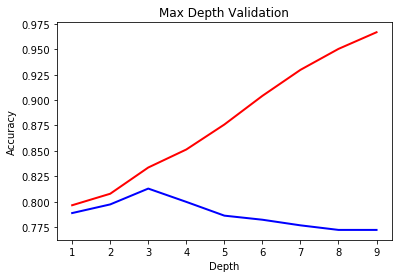

In [44]:
d_X_data = dirty_data
d_y_target = d_Target

train_data_score, test_data_score = validation_curve(DecisionTreeClassifier(),d_X_data,d_y_target,param_name='max_depth',param_range=range(1,10),cv=10,scoring="accuracy")
train_score_mean =np.mean(train_data_score, axis=1)
test_score_mean =np.mean(test_data_score, axis=1)

plt.title("Max Depth Validation")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
lw=2
plt.plot(range(1,10),train_score_mean,label="Training score",color="RED",lw=lw)
plt.plot(range(1,10),test_score_mean,label="Cross-validation score",color="BLUE",lw=lw)
plt.show()

In [45]:
d_tree = DecisionTreeClassifier(random_state=0,max_depth=3)
d_tree.fit(d_X_data,d_y_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

### Accuracy/Precision/Recall on dirty data set

In [46]:
print("Accuracy on Training set: %.4f"% (d_tree.score(d_X_data,d_y_target)))
print("Precision on Training set: %.4f"% (precision(d_y_target,d_tree.predict(d_X_data))))
print("Recall on Training set: %.4f"% (recall(d_y_target,d_tree.predict(d_X_data))))

Accuracy on Training set: 0.8360
Precision on Training set: 0.9003
Recall on Training set: 0.8305


## Top 10 Important Features for DecisionTreeClassifier

In [47]:
d_importance_tree = d_tree.feature_importances_
d_indices_tree = np.argsort(d_importance_tree)[::-1]
print("Top 10 Features used in classification.\n\n")
for f in range(0,4):
    print("%d. feature %d (%f)  ==> %s" % (f + 1, d_indices_tree[f], d_importance_tree[d_indices_tree[f]],dirty_data.columns[d_indices_tree[f]]))

Top 10 Features used in classification.


1. feature 44 (0.720020)  ==> PctKids2Par
2. feature 3 (0.168298)  ==> racePctWhite
3. feature 5 (0.091595)  ==> racePctHisp
4. feature 71 (0.020087)  ==> HousVacant


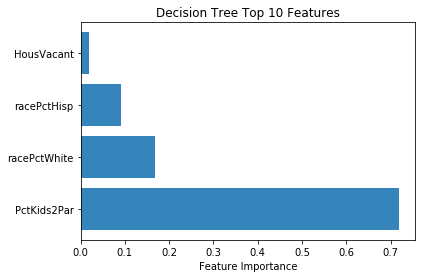

In [48]:
d_x_obj = []
for f in range(0,4):
    d_x_obj.append(dirty_data.columns[d_indices_tree[f]])
d_y_pos =np.arange(len(d_x_obj))
d_y_val =np.sort(d_importance_tree)[::-1][0:4]

plt.barh(d_y_pos,d_y_val,align='center',alpha=0.9)
plt.yticks(d_y_pos,d_x_obj)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Top 10 Features")

plt.show()


### Decision Tree 

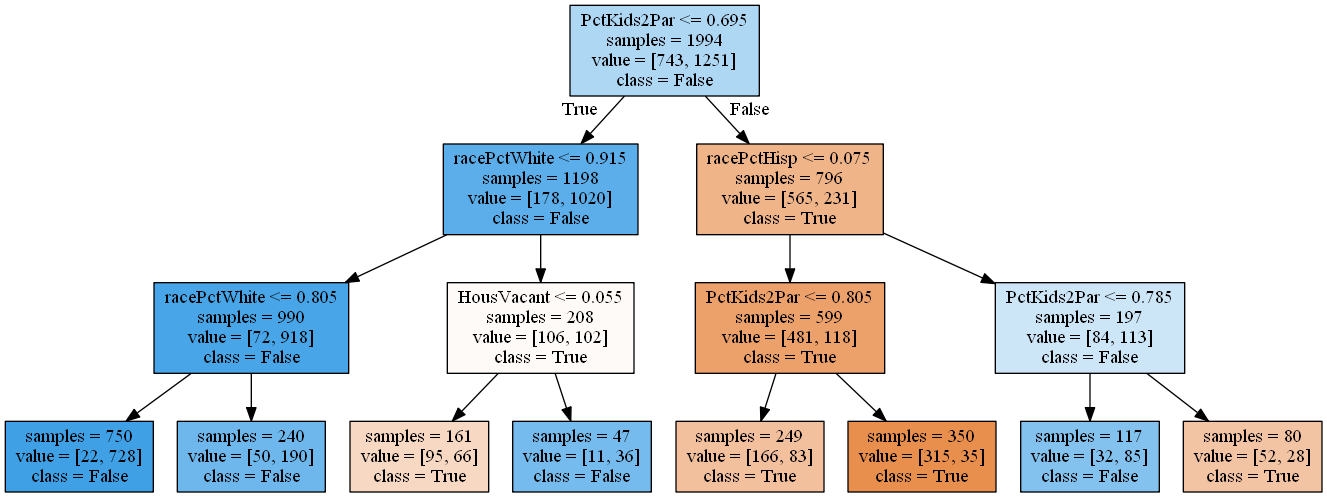

In [49]:
export_graphviz(d_tree, out_file="d_tree.dot", class_names=["True", "False"],
                feature_names=d_X_data.columns, impurity=False, filled=True)


d_graph = pydotplus.graph_from_dot_file('d_tree.dot')
#graph.write_png('tree.png')
Image(d_graph.create_png())

### 10-fold-cross-validation on dirty data

In [50]:
tree_accuracy=cross_val_score(d_tree,d_X_data,d_y_target,cv=10)
tree_precision = cross_val_score(d_tree,d_X_data,d_y_target,cv=10,scoring='precision')
tree_recall =cross_val_score(d_tree,d_X_data,d_y_target,cv=10,scoring='recall')

print("DecisionTreeClassifier Accuracy : %.4f (+/- %.4f)"% (tree_accuracy.mean(),tree_accuracy.std()*2))
print("DecisionTreeClassifier Precision: %.4f (+/- %.4f)"% (tree_precision.mean(),tree_precision.std()*2))
print("DecisionTreeClassifier Recall: %.4f (+/- %.4f)"% (tree_recall.mean(),tree_recall.std()*2))

DecisionTreeClassifier Accuracy : 0.8129 (+/- 0.0415)
DecisionTreeClassifier Precision: 0.8775 (+/- 0.0631)
DecisionTreeClassifier Recall: 0.8178 (+/- 0.0693)


### a.	Are the CV results better or worse? What does this say about the effect of missing values?

#### For the Dirty data sets , CV results arer betther compared to cleaned datasets. Because with the dirty data sets DecisionTreeClassifier can be model better compared to Cleaned Data set as  bias is present in the dataset. Missing values are replaceb by mean of the column and it will help to introduce bias in the model.

# Extra Credit

### Random Forest

#### Clean Data

In [51]:
random_forest_clf = RandomForestClassifier(random_state=0)
random_forest_clf.fit(X_data,y_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

#### Cross Validation Metrics

In [52]:
tree_accuracy=cross_val_score(random_forest_clf,X_data,y_target,cv=10)
tree_precision = cross_val_score(random_forest_clf,X_data,y_target,cv=10,scoring='precision')
tree_recall =cross_val_score(random_forest_clf,X_data,y_target,cv=10,scoring='recall')

print("DecisionTreeClassifier Accuracy : %.4f (+/- %.4f)"% (tree_accuracy.mean(),tree_accuracy.std()*2))
print("DecisionTreeClassifier Precision: %.4f (+/- %.4f)"% (tree_precision.mean(),tree_precision.std()*2))
print("DecisionTreeClassifier Recall: %.4f (+/- %.4f)"% (tree_recall.mean(),tree_recall.std()*2))

DecisionTreeClassifier Accuracy : 0.7912 (+/- 0.0944)
DecisionTreeClassifier Precision: 0.8466 (+/- 0.0598)
DecisionTreeClassifier Recall: 0.8192 (+/- 0.2067)


#### Most Predictive Features

In [53]:
importance_tree = random_forest_clf.feature_importances_
indices_tree = np.argsort(importance_tree)[::-1]
print("Top 10 Features used in classification.\n\n")
for f in range(0,4):
    print("%d. feature %d (%f)  ==> %s" % (f + 1, indices_tree[f], importance_tree[indices_tree[f]],data.columns[indices_tree[f]]))

Top 10 Features used in classification.


1. feature 43 (0.095354)  ==> PctFam2Par
2. feature 3 (0.052369)  ==> racePctWhite
3. feature 40 (0.050754)  ==> FemalePctDiv
4. feature 28 (0.047153)  ==> PctPopUnderPov


#### Dirty Data

In [54]:
d_random_forest_clf = RandomForestClassifier(random_state=0)
d_random_forest_clf.fit(d_X_data,d_y_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

#### Cross Validation Metrics

In [55]:
tree_accuracy=cross_val_score(d_random_forest_clf,d_X_data,d_y_target,cv=10)
tree_precision = cross_val_score(d_random_forest_clf,d_X_data,d_y_target,cv=10,scoring='precision')
tree_recall =cross_val_score(d_random_forest_clf,d_X_data,d_y_target,cv=10,scoring='recall')

print("DecisionTreeClassifier Accuracy : %.4f (+/- %.4f)"% (tree_accuracy.mean(),tree_accuracy.std()*2))
print("DecisionTreeClassifier Precision: %.4f (+/- %.4f)"% (tree_precision.mean(),tree_precision.std()*2))
print("DecisionTreeClassifier Recall: %.4f (+/- %.4f)"% (tree_recall.mean(),tree_recall.std()*2))

DecisionTreeClassifier Accuracy : 0.8234 (+/- 0.0450)
DecisionTreeClassifier Precision: 0.8783 (+/- 0.0573)
DecisionTreeClassifier Recall: 0.8353 (+/- 0.0427)


#### Most Predictive Features

In [56]:
d_importance_tree = d_random_forest_clf.feature_importances_
d_indices_tree = np.argsort(d_importance_tree)[::-1]
print("Top 10 Features used in classification.\n\n")
for f in range(0,4):
    print("%d. feature %d (%f)  ==> %s" % (f + 1, d_indices_tree[f], d_importance_tree[d_indices_tree[f]],dirty_data.columns[d_indices_tree[f]]))

Top 10 Features used in classification.


1. feature 43 (0.116207)  ==> PctFam2Par
2. feature 28 (0.054828)  ==> PctPopUnderPov
3. feature 45 (0.053003)  ==> PctYoungKids2Par
4. feature 3 (0.046017)  ==> racePctWhite


### Non Linear kernal for  SVM

#### Clean Data

In [57]:
non_linear_svm = svm.SVC(kernel='poly')
non_linear_svm.fit(X_data,y_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Cross Validation Metrics

In [58]:
accuracy_score = cross_val_score(non_linear_svm,X_data,y_target,cv=10)
precision_score = cross_val_score(non_linear_svm,X_data,y_target,cv=10,scoring='precision')
recall_score = cross_val_score(non_linear_svm,X_data,y_target,cv=10,scoring='recall')

print("Non Linear kernal for SVM  Accuracy: %0.3f (+/- %0.3f)"%(accuracy_score.mean(),accuracy_score.std()*2))
print("Non Linear kernal for SVM  Precision: %0.3f (+/- %0.3f)"%(precision_score.mean(),precision_score.std()*2))
print("Non Linear kernal for SVM  Recall: %0.3f (+/- %0.3f)"%(recall_score.mean(),recall_score.std()*2))

Non Linear kernal for SVM  Accuracy: 0.691 (+/- 0.075)
Non Linear kernal for SVM  Precision: 0.675 (+/- 0.056)
Non Linear kernal for SVM  Recall: 0.986 (+/- 0.035)


#### Dirty Data

In [59]:
d_non_linear_svm = svm.SVC(kernel='poly')
d_non_linear_svm.fit(d_X_data,d_y_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Cross Validation Metrics

In [60]:
tree_accuracy=cross_val_score(d_non_linear_svm,d_X_data,d_y_target,cv=10)
tree_precision = cross_val_score(d_non_linear_svm,d_X_data,d_y_target,cv=10,scoring='precision')
tree_recall =cross_val_score(d_non_linear_svm,d_X_data,d_y_target,cv=10,scoring='recall')

print("Non Linear kernal for SVM Accuracy : %.4f (+/- %.4f)"% (tree_accuracy.mean(),tree_accuracy.std()*2))
print("Non Linear kernal for SVM Precision: %.4f (+/- %.4f)"% (tree_precision.mean(),tree_precision.std()*2))
print("Non Linear kernal for SVM Recall: %.4f (+/- %.4f)"% (tree_recall.mean(),tree_recall.std()*2))

Non Linear kernal for SVM Accuracy : 0.6986 (+/- 0.0332)
Non Linear kernal for SVM Precision: 0.6788 (+/- 0.0247)
Non Linear kernal for SVM Recall: 0.9872 (+/- 0.0128)


### GradientBoostingClassifier 

#### Clean Data

In [61]:
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1,random_state=0)
gradientBoostingClassifier.fit(X_data,y_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

#### Cross Validation Metrics

In [62]:
accuracy_score = cross_val_score(gradientBoostingClassifier,X_data,y_target,cv=10)
precision_score = cross_val_score(gradientBoostingClassifier,X_data,y_target,cv=10,scoring='precision')
recall_score = cross_val_score(gradientBoostingClassifier,X_data,y_target,cv=10,scoring='recall')

print("GradientBoostingClassifier  Accuracy: %0.3f (+/- %0.3f)"%(accuracy_score.mean(),accuracy_score.std()*2))
print("GradientBoostingClassifier  Precision: %0.3f (+/- %0.3f)"%(precision_score.mean(),precision_score.std()*2))
print("GradientBoostingClassifier  Recall: %0.3f (+/- %0.3f)"%(recall_score.mean(),recall_score.std()*2))

GradientBoostingClassifier  Accuracy: 0.789 (+/- 0.071)
GradientBoostingClassifier  Precision: 0.843 (+/- 0.100)
GradientBoostingClassifier  Recall: 0.826 (+/- 0.195)


#### Most Predictive Features

In [63]:
importance_tree = gradientBoostingClassifier.feature_importances_
indices_tree = np.argsort(importance_tree)[::-1]
print("Top 10 Features used in classification.\n\n")
for f in range(0,10):
    print("%d. feature %d (%f)  ==> %s" % (f + 1, indices_tree[f], importance_tree[indices_tree[f]],data.columns[indices_tree[f]]))

Top 10 Features used in classification.


1. feature 75 (0.060000)  ==> PctVacMore6Mos
2. feature 44 (0.060000)  ==> PctKids2Par
3. feature 3 (0.040000)  ==> racePctWhite
4. feature 6 (0.040000)  ==> agePct12t21
5. feature 20 (0.030000)  ==> perCapInc
6. feature 34 (0.030000)  ==> PctEmplManu
7. feature 15 (0.030000)  ==> pctWInvInc
8. feature 94 (0.030000)  ==> PctSameCity85
9. feature 42 (0.030000)  ==> PersPerFam
10. feature 88 (0.030000)  ==> MedOwnCostPctIncNoMtg


#### Dirty Data

In [64]:
d_gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1,random_state=0)
d_gradientBoostingClassifier.fit(d_X_data,d_y_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

#### Cross Validation Metrics

In [65]:
accuracy_score = cross_val_score(d_gradientBoostingClassifier,d_X_data,d_y_target,cv=10)
precision_score = cross_val_score(d_gradientBoostingClassifier,d_X_data,d_y_target,cv=10,scoring='precision')
recall_score = cross_val_score(d_gradientBoostingClassifier,d_X_data,d_y_target,cv=10,scoring='recall')

print("GradientBoostingClassifier  Accuracy: %0.3f (+/- %0.3f)"%(accuracy_score.mean(),accuracy_score.std()*2))
print("GradientBoostingClassifier  Precision: %0.3f (+/- %0.3f)"%(precision_score.mean(),precision_score.std()*2))
print("GradientBoostingClassifier  Recall: %0.3f (+/- %0.3f)"%(recall_score.mean(),recall_score.std()*2))

GradientBoostingClassifier  Accuracy: 0.811 (+/- 0.035)
GradientBoostingClassifier  Precision: 0.848 (+/- 0.050)
GradientBoostingClassifier  Recall: 0.852 (+/- 0.055)


#### Most Predictive Features

In [66]:
d_importance_tree = d_gradientBoostingClassifier.feature_importances_
d_indices_tree = np.argsort(d_importance_tree)[::-1]
print("Top 10 Features used in classification.\n\n")
for f in range(0,10):
    print("%d. feature %d (%f)  ==> %s" % (f + 1, d_indices_tree[f], d_importance_tree[d_indices_tree[f]],dirty_data.columns[d_indices_tree[f]]))

Top 10 Features used in classification.


1. feature 75 (0.060000)  ==> PctVacMore6Mos
2. feature 44 (0.060000)  ==> PctKids2Par
3. feature 3 (0.040000)  ==> racePctWhite
4. feature 6 (0.040000)  ==> agePct12t21
5. feature 20 (0.030000)  ==> perCapInc
6. feature 34 (0.030000)  ==> PctEmplManu
7. feature 15 (0.030000)  ==> pctWInvInc
8. feature 94 (0.030000)  ==> PctSameCity85
9. feature 42 (0.030000)  ==> PersPerFam
10. feature 88 (0.030000)  ==> MedOwnCostPctIncNoMtg


## QUE:	What method gives the best results?

### ANS:  From the above three method,  DecisionTreeClassifier  gives better accuracy for Cleaned and  dirty  Datasets LinearSVC gives better result

### Algorithm Comparision for Cleaned Data

RF: 0.786191 (0.057595)
nlSVM: 0.691397 (0.037287)
GBoost: 0.789221 (0.035580)
DT: 0.798244 (0.059135)
GNB: 0.761608 (0.054241)
SVM: 0.796234 (0.054686)


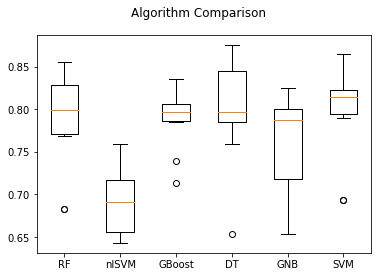

In [67]:
models =[]
models.append(("RF",RandomForestClassifier()))
models.append(("nlSVM",svm.SVC(kernel='poly')))
models.append(("GBoost",GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1,random_state=0)))
models.append(("DT",DecisionTreeClassifier(random_state=0,max_depth=3)))
models.append(("GNB",GaussianNB()))
models.append(("SVM",svm.LinearSVC()))



results=[]
names=[]
scoring='accuracy'
for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(model, X_data, y_target, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
    


#### Algorithm Comparision for Dirty Data

RF: 0.817406 (0.015886)
nlSVM: 0.698607 (0.016611)
GBoost: 0.810916 (0.017271)
DT: 0.812946 (0.020768)
GNB: 0.777290 (0.021370)
SVM: 0.829974 (0.018139)


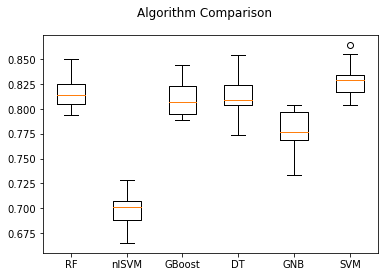

In [68]:
models =[]
models.append(("RF",RandomForestClassifier()))
models.append(("nlSVM",svm.SVC(kernel='poly')))
models.append(("GBoost",GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1,random_state=0)))
models.append(("DT",DecisionTreeClassifier(random_state=0,max_depth=3)))
models.append(("GNB",GaussianNB()))
models.append(("SVM",svm.LinearSVC()))



results=[]
names=[]
scoring='accuracy'
for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(model, d_X_data, d_y_target, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
    


# 


## QUE:	What feature(s) seem to be most consistently predictive of high crime rates?
### ANS:  From the above methods,  'PctKids2Par' is the most consistent features in predicting High Crime Rates.